In [1]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import packages

import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [3]:
# Prepare file paths

dir1 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/images/train'
dir2 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/images/val'
dir3 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/images/test'

dir4 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/masks/train'
dir5 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/masks/val'
dir6 = r'/content/drive/MyDrive/Projects (Self)/Face Mask Segmentation/data/masks/test'

In [4]:
# Prepare list of file names for each file path

images_train_filenames = [file for file in os.listdir(dir1)]
images_val_filenames = [file for file in os.listdir(dir2)]
images_test_filenames = [file for file in os.listdir(dir3)]

masks_train_filenames = [file for file in os.listdir(dir4)]
masks_val_filenames = [file for file in os.listdir(dir5)]
masks_test_filenames = [file for file in os.listdir(dir6)]

images_train_filenames.sort()
images_val_filenames.sort()
images_test_filenames.sort()
masks_train_filenames.sort()
masks_val_filenames.sort()
masks_test_filenames.sort()

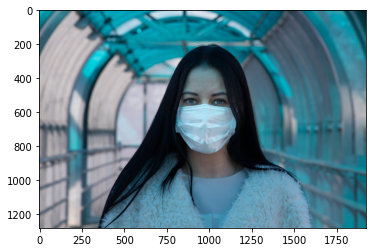

In [5]:
# Example of an image in the train set

path = os.path.join(dir1, images_train_filenames[0])
img = torchvision.io.read_image(path)
plt.imshow(img.permute(1,2,0))

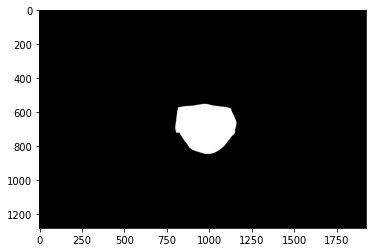

In [6]:
# Corresponding mask in the train set

path = os.path.join(dir4, masks_train_filenames[0])
img = torchvision.io.read_image(path)
plt.imshow(img.permute(1,2,0))

In [7]:
# Transformations to be applied

transforms = torch.nn.Sequential(
    torchvision.transforms.Resize((144, 120)),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True)
)
script_trans = torch.jit.script(transforms)

In [8]:
# Load the images data

images_train = []
for each in images_train_filenames:
    path = os.path.join(dir1, each)
    img = torchvision.io.read_image(path)
    images_train.append(script_trans(img.to(torch.float32)))

images_val = []
for each in images_val_filenames:
    path = os.path.join(dir2, each)
    img = torchvision.io.read_image(path)
    images_val.append(script_trans(img.to(torch.float32)))

images_test = []
for each in images_test_filenames:
    path = os.path.join(dir3, each)
    img = torchvision.io.read_image(path)
    images_test.append(script_trans(img.to(torch.float32)))

In [9]:
# Load segmentation masks data

masks_train = []
for each in masks_train_filenames:
    path = os.path.join(dir4, each)
    img = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.RGB)
    masks_train.append(script_trans(img.to(torch.float32)))

masks_val = []
for each in masks_val_filenames:
    path = os.path.join(dir5, each)
    img = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.RGB)
    masks_val.append(script_trans(img.to(torch.float32)))

masks_test = []
for each in masks_test_filenames:
    path = os.path.join(dir6, each)
    img = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.RGB)
    masks_test.append(script_trans(img.to(torch.float32)))

In [10]:
# Initialize Model class

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 4, 1, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 4, 1, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 4, 1, padding='same')
        self.transconv1 = nn.ConvTranspose2d(64, 32, 2, 1)
        self.transconv2 = nn.ConvTranspose2d(32, 32, 2, 1) 
        self.transconv3 = nn.ConvTranspose2d(32, 3, 1, 1)
                                             
        self.mp1 = nn.MaxPool2d(2, 1)
        self.mp2 = nn.MaxPool2d(2, 1)   
    
        self.bn1 = nn.BatchNorm2d(32, affine=False)
        self.bn2 = nn.BatchNorm2d(32, affine=False)
        self.bn3 = nn.BatchNorm2d(64, affine=False)
        self.bn4 = nn.BatchNorm2d(64, affine=False)
        self.bn5 = nn.BatchNorm2d(32, affine=False)
        self.bn6 = nn.BatchNorm2d(32, affine=False)
        self.bn7 = nn.BatchNorm2d(3, affine=False)

        self.rl1 = nn.ReLU()
        self.rl2 = nn.ReLU()
        self.rl3 = nn.ReLU()
        self.rl4 = nn.ReLU()
        self.rl5 = nn.ReLU()
        self.rl6 = nn.ReLU()
        self.rl7 = nn.ReLU()

    def forward(self, input):
        input = self.rl1(self.bn1(self.conv1(input)))
        input = self.rl2(self.bn2(self.conv2(input)))
        input = self.mp1(input)
        input = self.rl3(self.bn3(self.conv3(input)))
        input = self.rl4(self.bn4(self.conv4(input)))
        input = self.mp2(input)
        input = self.rl5(self.bn5(self.transconv1(input)))
        input = self.rl6(self.bn6(self.transconv2(input)))
        output = self.rl7(self.bn7(self.transconv3(input)))

        return output

In [11]:
model = Model().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.8, dampening=0.1, weight_decay=0, nesterov=False)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.35, lr_decay=0.1, weight_decay=0.4) # Worked well for output
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, alpha=0.99, weight_decay=0, momentum=0.6, centered=False)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [12]:
# Train the model 

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

epoch = 50
for each in range(1, epoch+1):
    total_train_loss, total_val_loss = 0, 0
    
    for train_image in images_train:
        for train_mask in masks_train:
            train_image = torch.unsqueeze(train_image, 0)
            train_image = train_image.to(torch.float32).to(device)
            train_mask = torch.unsqueeze(train_mask, 0)
            train_mask = train_mask.to(torch.float32).to(device)
            output = model(train_image) 
            train_loss = loss(train_mask, output)
            total_train_loss += train_loss
            optimizer.zero_grad()
            train_loss.backward(retain_graph=False)
            optimizer.step()
            train_image.detach()
            train_mask.detach()
            break

    for val_image in images_val:
        for val_mask in masks_val:
            val_image = torch.unsqueeze(val_image, 0)
            val_image = val_image.to(torch.float32).to(device)
            val_mask = torch.unsqueeze(val_mask, 0)
            val_mask = val_mask.to(torch.float32).to(device)
            output = model(val_image)
            val_loss = loss(val_mask, output)
            total_val_loss += val_loss
            val_image.detach()
            val_mask.detach()
            break
    
    total_train_loss /= len(images_train)
    total_val_loss /= len(images_val)

    if each == 1 or each%10 == 0:
        print('The value of train_loss at epoch {}: {}'.format(each, total_train_loss))
        print('The value of val_loss at epoch {}: {}'.format(each, total_val_loss))
        print()

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

print("The best val_loss achieved is: {}".format(best_val_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:440: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The value of train_loss at epoch 1: 41850.5703125
The value of val_loss at epoch 1: 2361.34375

The value of train_loss at epoch 10: 41828.34375
The value of val_loss at epoch 10: 2361.56298828125

The value of train_loss at epoch 20: 41811.25390625
The value of val_loss at epoch 20: 2361.260498046875

The value of train_loss at epoch 30: 41790.515625
The value of val_loss at epoch 30: 2361.23486328125

The value of train_loss at epoch 40: 41772.8671875
The value of val_loss at epoch 40: 2361.163330078125

The value of train_loss at epoch 50: 41751.984375
The value of val_loss at epoch 50: 2361.641845703125

The best val_loss achieved is: 2360.870361328125


In [13]:
# Make predictions on test data

model.load_state_dict(best_model_wts)
total_test_loss = 0
predictions = []
for test_image in images_test:
    test_image = torch.unsqueeze(test_image, 0)
    test_image = test_image.to(torch.float32).to(device)
    output = model(test_image)
    predictions.append(output)
    test_image.detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


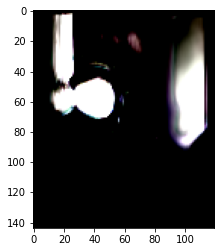

In [14]:
# Display output generated by model

display_img = torch.squeeze(predictions[7], 0).cpu()
display_img = display_img.detach().numpy()
display_img = torch.Tensor(display_img)
plt.imshow(display_img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


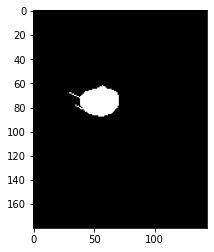

In [60]:
# Corresponding ground truth mask for the above prediction

plt.imshow(masks_test[7].permute(1,2,0))